# Rebar Recombinants Analysis

This notebook contains supplementary analyses of the 929 recombinants identified in the `sc2ts` paper when analysed by rebar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
recombinants_csv = "../arg_postprocessing/sc2ts_v1_2023-02-21_pp_dated_remapped_bps_pango_recombinants_rebar_matches_pangonet_nsl.csv"
rebar_tsv = "../arg_postprocessing/sc2ts_v1_2023-02-21_pp_dated_remapped_bps_pango_rebar_output.tsv"

## Compare

### Data

In [3]:
df_sc2ts = pd.read_csv(recombinants_csv).set_index("sample_id")
# df_sc2ts.head(5)
len(df_sc2ts)

929

In [4]:
df_rebar = pd.read_csv(rebar_tsv, sep="\t").set_index("strain")
# df_rebar.head(5)
len(df_rebar)

929

In [5]:
# NOTE: recombinant in the sc2ts file is the recombinant node ID.
dfj = df_sc2ts.join(df_rebar, rsuffix="_rebar")
dfj.columns

Index(['recombinant', 'num_descendant_samples', 'num_samples',
       'distinct_sample_pango', 'interval_left', 'interval_right',
       'num_mutations', 'Viridian_amplicon_scheme', 'Artic_primer_version',
       'date_added', 'group_id', 'group_size', 'recombinant_pango',
       'recombinant_scorpio', 'recombinant_time', 'recombinant_date', 'sample',
       'sample_pango', 'sample_scorpio', 'sample_time', 'sample_date',
       'parent_left', 'parent_left_pango', 'parent_left_scorpio',
       'parent_left_time', 'parent_left_date', 'parent_right',
       'parent_right_pango', 'parent_right_scorpio', 'parent_right_time',
       'parent_right_date', 'parent_mrca', 'parent_mrca_pango',
       'parent_mrca_scorpio', 'parent_mrca_time', 'parent_mrca_date', 'diffs',
       'max_run_length', 'is_rebar_recombinant', 'num_mutations_k1000',
       'num_mutations_k4', 'parent_pangonet_distance',
       'net_min_supporting_loci_lft', 'net_min_supporting_loci_rgt',
       'net_min_supporting_loci_l

In [6]:
rebar_status = np.full(len(df_rebar), "known")
rebar_status[dfj["recombinant_rebar"] == "novel"] = "novel"
rebar_status[dfj["recombinant_rebar"].isna()] = "not"

dfj["rebar_status"] = rebar_status

### Filter

In [7]:
dfj["rebar_status"].value_counts()

rebar_status
not      703
novel    158
known     68
Name: count, dtype: int64

Overall, we have 158 recombinants marked as novel by rebar. How does this cluster by high quality flag?

In [8]:
dfj["high_quality"] = dfj["net_min_supporting_loci_lft_rgt_ge_4"]
np.sum(dfj["high_quality"])

np.int64(385)

In [9]:
dfj["high_quality"].value_counts()

high_quality
False    544
True     385
Name: count, dtype: int64

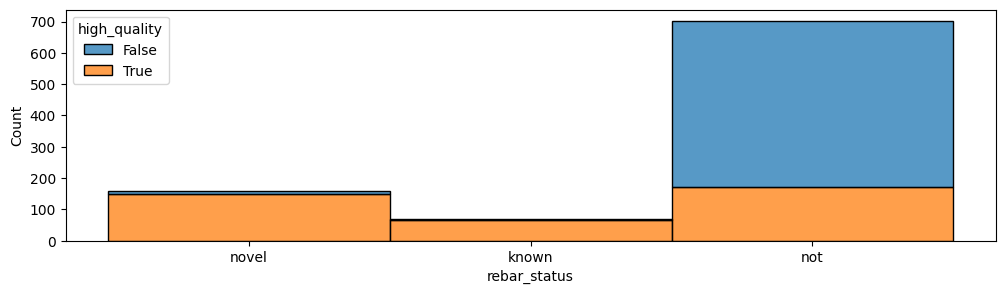

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.histplot(data=dfj, stat="count", multiple="stack",
             x="rebar_status", kde=False,
            hue="high_quality",
             element="bars", legend=True, ax=ax);

In [11]:
np.sum((dfj["rebar_status"] == "not") & np.logical_not(dfj["high_quality"]))

np.int64(532)

The high-quality flag is very highly correlated with rebar status "not recombinant", with 532 of the 544 recombinants that we're not confident in being flagged as not recombinant by rebar.

Let's focus on the high quality set now

No, as it happens the vast majority of the errors have a run length of 5. So let's exclude these.

In [12]:
df_hq = dfj[dfj.high_quality]
df_hq

,recombinant,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,edge_case,unique_key,regions,substitutions,genome_length,dataset_name,dataset_tag,cli_version,rebar_status,high_quality
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR4437465,1530,1,1,1,8783,13617,2,COVID-ARTIC-V3,3,2020-03-22,...,False,novel_A_B.1_8783-14407,"241-8782|A,14408-23403|B.1","C8782T|A;C14408T,A20268G,A23403G|B.1;C850T,C64...",29903,sars-cov-2,2025-01-28,0.2.0,novel,True
ERR4615866,26465,54,1,1,15325,21855,1,COVID-ARTIC-V3,3,2020-08-24,...,False,novel_B.1.177_B.1.221_15325-20660,"222-15324|B.1.177,20661-29645|B.1.221","C222T,T445C,C6286T|B.1.177;C21855T,A23403G,A25...",29903,sars-cov-2,2025-01-28,0.2.0,novel,True
ERR4671078,27003,3,1,1,22993,25563,2,COVID-ARTIC-V3,3,2020-08-26,...,False,novel_B.1.160_B.1.1_22993-25562,"4543-22992|B.1.160,25563-29399|B.1.1","C4543T,G5629T,G9526T,C11497T,G13993T,C14408T,G...",29903,sars-cov-2,2025-01-28,0.2.0,novel,True
SRR21719160,28379,3,1,1,6542,9515,0,COVID-ARTIC-V3,.,2020-09-02,...,False,NaN,NaN,"C241T,C1059T,C3037T,C14408T,A22320G,A23403G,G2...",29903,sars-cov-2,2025-01-28,0.2.0,not,True
ERR4760005,34811,1,1,1,11523,25049,2,COVID-ARTIC-V3,3,2020-09-30,...,False,NaN,NaN,"G204T,C241T,T445C,C3037T,C6286T,C7926T,C9745T,...",29903,sars-cov-2,2025-01-28,0.2.0,not,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR10839902,1429711,2,1,1,19327,20428,1,COVID-ARTIC-V4.1,4.1alt,2023-01-22,...,False,XCE_BQ.1_XCE_19327-21809,"9424-19326|BQ.1,21810-27915|XCE","A9424G,C11750T,G12160A,T14257C,G16935A|BQ.1;T2...",29903,sars-cov-2,2025-01-28,0.2.0,known,True
ERR10839848,1430261,1,1,1,19327,20741,2,COVID-ARTIC-V4.1,4.1alt,2023-01-23,...,False,XCT_BJ.1_CH.1.1.2_18584-20740,"405-18583|BJ.1,20741-29118|CH.1.1.2","A405G,C15738T,T15939C,T16342C,T17859C|BJ.1;A20...",29903,sars-cov-2,2025-01-28,0.2.0,known,True
SRR23358540,1430452,1,1,1,9867,12160,1,COVID-ARTIC-V4.1,.,2023-01-23,...,False,novel_BQ.1.1.78_CH.1.1.2_11751-12159,"2954-11750|BQ.1.1.78,12160-28681|CH.1.1.2","T2954C,C11750T|BQ.1.1.78;A12444G,C12880T,C1440...",29903,sars-cov-2,2025-01-28,0.2.0,novel,True


In [13]:
df_hq["recombinant_rebar"].value_counts(dropna=False)

recombinant_rebar
NaN      171
novel    149
XM         7
XS         6
XAS        6
XAN        5
XAB        4
XAP        4
XY         3
XAJ        3
XA         3
XG         2
XBM        2
XBD        2
XF         1
XC         1
XL         1
XQ         1
XJ         1
XAR        1
XE         1
XAF        1
XW         1
XU         1
XBG        1
XBH        1
XBE        1
XBB        1
XBR        1
XBF        1
XCE        1
XCT        1
Name: count, dtype: int64

FIXME The notebook doesn't run from this point on - it wasn't in a running state when previously committed and it looks like there's a lot of duplicated code here in terms of comparing with other methods


### Disagreement

In [14]:
# TODO: Revisit.
import copy

df_nonrecomb[
  (df_nonrecomb["num_mutations"] >= 3) & (df_nonrecomb["parent_left_pango"] != df_nonrecomb["parent_right_pango"])
][["parent_left_pango", "parent_right_pango"]]

is_rebar_candidate = [False for _ in range(0, len(df_nonrecomb))]
for i,data in enumerate(df_nonrecomb.iterrows()):
    index, row = data
    if row["num_mutations"] < 3: continue
    # Check for equivalent or sister taxa
    p1, p2 = row["parent_left_pango"], row["parent_right_pango"]
    if p1 == p2: continue
    anc, desc = pangonet.get_ancestors(p1), pangonet.get_descendants(p1)
    if p2 in anc or p2 in desc: continue         
    is_rebar_candidate[i] = True

df_nonrecomb["is_rebar_candidate"] = is_rebar_candidate
df_nonrecomb[df_nonrecomb["is_rebar_candidate"]][["parent_left_pango", "parent_right_pango", "num_mutations"]]

NameError: name 'df_nonrecomb' is not defined

### Compare parent Pango identities

In [ ]:
df_recomb = df_recomb\
    .assign(parent_left_rebar = [x.split(",")[0] for x in df_recomb["parents"]])\
    .assign(parent_right_rebar = [x.split(",")[1] for x in df_recomb["parents"]])\
    .assign(breakpoint_left_rebar = [int(x.split("-")[0]) for x in df_recomb["breakpoints"]])\
    .assign(breakpoint_right_rebar = [int(x.split("-")[1]) for x in df_recomb["breakpoints"]])

In [ ]:
is_parents_concordant = np.zeros(len(df_recomb), dtype=bool)
i = 0
for index, row in df_recomb.iterrows():
    concordant_count = 0
    for p in ["left", "right"]:
        p_rebar = row[f"parent_{p}_rebar"]
        anc_rebar = pangonet.get_ancestors(p_rebar)
        desc_rebar = pangonet.get_descendants(p_rebar)
        p_sc2ts = row[f"parent_{p}_pango"]

        concordant = (p_rebar == p_sc2ts) or \
            (p_sc2ts in anc_rebar) or \
            (p_sc2ts in desc_rebar)
        # TBD: We could put a distance check here to make sure they're not
        # extremely distant related.
        concordant_count += 1 if concordant else 0

    # If both parents are concordant
    if concordant_count == 2:
        is_parents_concordant[i] = 1
    i +=1
df_recomb = df_recomb.assign(is_parents_concordant = is_parents_concordant)

In [ ]:
num_concordant = len(df_recomb[df_recomb['is_parents_concordant']])
perc_concordant = round((num_concordant / len(df_recomb) ) * 100, 1)
print(f"Concordant Parents: {num_concordant}/{len(df_recomb)} ({perc_concordant}%)")

In [ ]:
pd.set_option('display.max_rows', 100)
df_recomb.loc[
    ~df_recomb["is_parents_concordant"],
    [
        "descendants",
        "sample_pango",
        "parent_left_pango",    # sc2ts
        "parent_left_rebar",
        "parent_right_pango",   # sc2ts
        "parent_right_rebar",
    ]
]

### Compare breakpoint intervals

In [ ]:
# TODO: Refactor and move to utils.
def overlap_breakpoint_intervals(*, rebar_interval, sc2ts_interval):
    assert rebar_interval[0] < rebar_interval[1]
    assert sc2ts_interval[0] < sc2ts_interval[1]
    # NOTE: rebar reports closed intervals spanning regions ambiguously assigned to parents.
    # Adjust the rebar coordinates so they are comparable to sc2ts.
    rebar_interval_adj = (rebar_interval[0] - 1, rebar_interval[1] + 1)
    rebar_size = rebar_interval_adj[1] - rebar_interval_adj[0]
    sc2ts_size = sc2ts_interval[1] - sc2ts_interval[0]
    def _get_overlap(a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))
    overlap_size = _get_overlap(a=rebar_interval_adj, b=sc2ts_interval)
    is_overlap_with_rebar = overlap_size > 0
    overlap_rebar_size_ratio = overlap_size / rebar_size
    sc2ts_rebar_size_ratio = sc2ts_size / rebar_size
    interval_distance = max(
        0,
        max(
            rebar_interval_adj[0] - sc2ts_interval[1],
            sc2ts_interval[0] - rebar_interval_adj[1],
        )
    )
    return (
        is_overlap_with_rebar,
        overlap_rebar_size_ratio,
        sc2ts_rebar_size_ratio,
        interval_distance,
    )


is_overlap_with_rebar = np.zeros(len(df_recomb), dtype=bool)
overlap_rebar_size_ratio = np.zeros(len(df_recomb), dtype=np.float32)
sc2ts_rebar_size_ratio = np.zeros(len(df_recomb), dtype=np.float32)
interval_distance = np.zeros(len(df_recomb), dtype=np.float32)

i = 0
for index, row in df_recomb.iterrows():
    (
        is_overlap_with_rebar[i], 
        overlap_rebar_size_ratio[i], 
        sc2ts_rebar_size_ratio[i],
        interval_distance[i],
    ) = overlap_breakpoint_intervals(
        rebar_interval=(row["breakpoint_left_rebar"], row["breakpoint_right_rebar"]),
        sc2ts_interval=(row["interval_left"], row["interval_right"]),
    )
    i += 1

df_recomb = df_recomb\
    .assign(is_overlap_with_rebar = is_overlap_with_rebar)\
    .assign(overlap_rebar_size_ratio = overlap_rebar_size_ratio)\
    .assign(sc2ts_rebar_size_ratio = sc2ts_rebar_size_ratio)\
    .assign(interval_distance = interval_distance)

df_recomb[
    [
        "interval_left",
        "interval_right",
        "breakpoint_left_rebar",
        "breakpoint_right_rebar",
        "is_overlap_with_rebar",
    ]
]

In [ ]:
num_concordant = len(df_recomb[df_recomb['is_overlap_with_rebar']])
perc_concordant = round((num_concordant / len(df_recomb) ) * 100, 1)
print(f"Concordant Breakpoints: {num_concordant}/{len(df_recomb)} ({perc_concordant}%)")

In [ ]:
# TODO: Refactor and move to utils.
def plot_breakpoint_interval_properties(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 2))
    fig.suptitle(title)
    ax[0].set_ylabel("Number of recombinants")
    ax[0].set_xlabel("Interval overlap size / rebar interval size")
    ax[0].hist(df["overlap_rebar_size_ratio"], bins=30)
    ax[1].set_xlabel("sc2ts interval size / rebar interval size")
    ax[1].hist(df["sc2ts_rebar_size_ratio"], bins=30)
    ax[2].set_xlabel("Distance between intervals")
    ax[2].hist(df["interval_distance"], bins=30, log=True);

In [ ]:
plot_breakpoint_interval_properties(df_recomb, title="Breakpoint intervals: All recombinants")

In [ ]:
plot_breakpoint_interval_properties(
    df_recomb[df_recomb["recombinant_rebar"] == "novel"],
    title="Breakpoint intervals: Novel recombinants",
)

In [ ]:
plot_breakpoint_interval_properties(
    df_recomb[df_recomb["recombinant_rebar"] != "novel"],
    title="Breakpoint intervals: Known recombinants",
)

In [ ]:
# Cases where the breakpoint intervals do not overlap.
df_recomb.loc[
    ~df_recomb["is_overlap_with_rebar"],
    [
        "sample_pango",
        "recombinant_rebar",
        "descendants",
        "interval_left",
        "interval_right",
        "breakpoint_left_rebar",
        "breakpoint_right_rebar",
        "overlap_rebar_size_ratio",
        "sc2ts_rebar_size_ratio",
        "interval_distance",
    ]
].sort_values(by="recombinant_rebar")

### Explore sensitivity between sc2ts and rebar

In [ ]:
node_dist = []
for i, row in df_hq.iterrows():
    if row["parent_left_pango"] == "Unknown (R)" or row["parent_right_pango"] == "Unknown (R)":
        node_dist.append(-1)
        continue
    if row["parent_left_pango"].startswith("X") or row["parent_right_pango"].startswith("X"):
        node_dist.append(-1)
        continue
    d = nb_utils.get_pangonet_distance(
        pangonet=pangonet,
        label_1=row["parent_left_pango"],
        label_2=row["parent_right_pango"],
    )
    node_dist.append(d)

In [ ]:
# Exclude these cases.
len([x for x in node_dist if x == -1])

In [ ]:
df_hq_nd = df_hq.assign(node_distance=node_dist)
df_hq_nd = df_hq_nd[df_hq_nd["node_distance"] >= 0]
df_hq_nd.head(1)

In [ ]:
recomb_nd = df_hq_nd[~df_hq_nd["recombinant_rebar"].isna()].node_distance
nonrecomb_nd = df_hq_nd[df_hq_nd["recombinant_rebar"].isna()].node_distance

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
nb_utils.draw_stacked_histogram(
    a=recomb_nd,
    b=nonrecomb_nd,
    ax=ax,
    alegend='Recombinant as per rebar',
    blegend='Non-recombinant as per rebar',
    xlabel='pangonet distance between sc2ts-identified parents',
    ylabel='Count of recombination nodes',
    xlim=[0, 20],
);

### Explore relationship with number of averted mutations

In [ ]:
is_rebar_recomb = df_hq["recombinant_rebar"].isna()
rebar_nonrecomb = df_hq[is_rebar_recomb].num_mutations_averted
rebar_recomb = df_hq[~is_rebar_recomb].num_mutations_averted

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
nb_utils.draw_stacked_histogram(
    a=rebar_recomb,
    b=rebar_nonrecomb,
    ax=ax,
    alegend='Recombinant as per rebar',
    blegend='Non-recombinant as per rebar',
    xlabel='Number of averted mutations',
    ylabel='Count of recombinants',
    xlim=[4, 25],
);

## Summary

### Recombinants

- There are 213 recombinants detected by both `rebar` and `sc2ts`.
- 182/213 (85.4%) have concordant parents, based on a non-sister taxa relationship.
- 201/213 (94.4%) have overlapping breakpoints.
- Parents that are not concordant tend to be close sister taxa (ex. `BA.5.2.21` vs. `BA.5.2.6`).

### Non-Recombinants

- There are 355 recombinants detected by `sc2ts` but not `rebar`.
- Only 23/355 are rebar candidates (based on number of mutations, parents as sister taxa).